# Import packages

In [1]:
import os
import re
from doctr.io import decode_img_as_tensor
from doctr.models import recognition_predictor
import pandas as pd
import torch
from torchvision.io import decode_image
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
from utils.plot import plot
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from huggingface_hub import login

/Users/franz143/Documents/Workspaces/Projects/cctv-footage-datetime-ocr/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Core functions

In [2]:
def extractDateTimeStrPipeline(ocrRecognitionModel, llm_pipeline, imageFilePath, customTransform = None):
    imgTensor, img = imageToTensorProcessor(imageFilePath, transforms.Compose(customTransform))
    recognitionResult, recognitionConfidence = ocrRecognition_extractString(ocrRecognitionModel, imgTensor)
    recognitionResultBuilder = [recognitionResult]
    if customTransform:
        customTransformWithInvert = [*customTransform, v2.RandomInvert(p=1.0)]
        imgTensorInverted, imgInverted = imageToTensorProcessor(imageFilePath, transforms.Compose(customTransformWithInvert))
        recognitionResult2, recognitionConfidence2 = ocrRecognition_extractString(ocrRecognitionModel, imgTensorInverted)
        recognitionResultBuilder = [*recognitionResultBuilder, recognitionResult2]
        
    # return llm_dateTimeStringValidate(llm_model, llm_tokenizer, recognitionResultBuilder)
    return llm_dateTimeStringValidateV2(llm_pipeline, recognitionResultBuilder)
    # llm_dateTimeStringValidateV2

def ocrRecognition_extractString(ocrRecognitionModel, imageTensor):
    recognitionOutput = ocrRecognitionModel([imageTensor])                
    return recognitionOutput[0][0], recognitionOutput[0][1]

def llm_dateTimeStringValidate(llm_model, llm_tokenizer, recognitionOutputStrList):
    systemContentPrompt = """
    You are a timestamp normalizer.

    You will receive multiple OCR outputs extracted from the same image.
    Each OCR output may contain errors, missing characters, or wrong separators.
    
    Your task:
    1. Identify the most plausible date and time by comparing all OCR inputs.
    2. Prefer values that:
       - Appear consistently across multiple inputs
       - Form a valid calendar date and valid time
       - Use a real 3-letter weekday (Mon Tue Wed Thu Fri Sat Sun)
    3. If some fields differ, choose the value that makes the full timestamp valid.
    4. Ignore extra text, noise, or invalid characters.
    5. Do NOT explain your reasoning.
    
    Output rules (STRICT):
    - Output ONLY one line
    - Use EXACT format:
      "<mm>-<dd>-<yyyy> <3-letter-week> <hh>:<mm>:<ss>"
    - Zero-pad all numbers to two digits
    - Do not add quotes
    - Do not add extra text
    - DON'T FORGET TO ADD SPACE BETWEEN <yyyy> and <3-letter-week>
    - DON'T FORGET TO ADD SPACE BETWEEN <3-letter-week> and <hh>
    """
    
    userContentPrompt = f"""
    OCR results from different models:

    OCR_1: {recognitionOutputStrList[0]}
    OCR_2: {recognitionOutputStrList[1]}
    
    Return the correct timestamp.
    """
    
    messages = [
        {"role": "system", "content": systemContentPrompt},
        {"role": "user", "content": userContentPrompt}
    ]
    text = llm_tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = llm_tokenizer([text], return_tensors="pt").to(llm_model.device)
    
    generated_ids = llm_model.generate(
        **model_inputs,
        max_new_tokens=512,
        pad_token_id=llm_tokenizer.eos_token_id
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    
    response = llm_tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response

def llm_dateTimeStringValidateV2(llm_pipeline, recognitionOutputStrList):
    systemContentPrompt = """
    You are a timestamp normalizer.

    You will receive multiple OCR outputs extracted from the same image.
    Each OCR output may contain errors, missing characters, or wrong separators.
    
    Your task:
    1. Identify the most plausible date and time by comparing all OCR inputs.
    2. Prefer values that:
       - Appear consistently across multiple inputs
       - Form a valid calendar date and valid time
       - Use a real 3-letter weekday (Mon Tue Wed Thu Fri Sat Sun)
    3. If some fields differ, choose the value that makes the full timestamp valid.
    4. Ignore extra text, noise, or invalid characters.
    5. Do NOT explain your reasoning.
    6. DON'T FORGET TO ADD SPACE BETWEEN <yyyy> and <3-letter-week>
    7. DON'T FORGET TO ADD SPACE BETWEEN <3-letter-week> and <hh>
    
    Output rules (STRICT):
    - Output ONLY one line
    - Use EXACT format:
      "<mm>-<dd>-<yyyy> <3-letter-week> <hh>:<mm>:<ss>"
    - Zero-pad all numbers to two digits
    - Do not add quotes
    - Do not add extra text
    """
    
    userContentPrompt = f"""
    OCR results from different models:

    OCR_1: {recognitionOutputStrList[0]}
    OCR_2: {recognitionOutputStrList[1]}
    
    Return the correct timestamp.
    """
    
    messages = [
        {"role": "system", "content": systemContentPrompt},
        {"role": "user", "content": userContentPrompt},
    ]
    outputs = llm_pipeline(
        messages,
        max_new_tokens=256,
    )
    return outputs[0]["generated_text"][-1]['content']

def imageToTensorProcessor(imgFilePath, customTransform = None):
    img = decode_image(imgFilePath)
    transform = transforms.Compose([
        v2.RandomAutocontrast(p=1.0),
        # v2.RandomAdjustSharpness(p=1.0, sharpness_factor=1.2),
        # v2.RandomInvert(p=1.0),
    ])
    if customTransform:
        img = customTransform(img)
    else:
        img = transform(img)
    
    # Convert to NumPy HWC
    img_np = img.permute(1, 2, 0).cpu().numpy()
        
    return img_np, img



# Initialization

In [9]:
ocrRecognitionModel = recognition_predictor('crnn_vgg16_bn', pretrained=True)
# llm_model_name = "Qwen/Qwen2.5-3B-Instruct"
# meta-llama/Llama-3.2-3B-Instruct
# llm_model_name = "meta-llama/Llama-3.2-3B-Instruct"
# llm_model = AutoModelForCausalLM.from_pretrained(
#     llm_model_name,
#     torch_dtype="auto",
#     device_map="cpu"
# )
# llm_tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
llm_model_name = "meta-llama/Llama-3.2-3B-Instruct"
llm_pipeline = pipeline(
    "text-generation",
    model=llm_model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# Custom Transforms per camera location
CAMERA_LOC_TRANSFORMS = {
    "D1": [
        v2.RandomAutocontrast(p=1.0),
        transforms.Lambda(lambda img: F.crop(
            img,
            top=0,
            left=2,
            height=54,
            width=928
        ))
    ],
    "D2": [
        v2.RandomAutocontrast(p=1.0),
        transforms.Lambda(lambda img: F.crop(
            img,
            top=0,
            left=5,
            height=60,
            width=930
        ))
    ],
}



Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.06s/it]


# Pipeline usage demo

In [10]:
print(extractDateTimeStrPipeline(
    ocrRecognitionModel,
    llm_pipeline,
    "testdata/D1.12-01-2025 Mon 10:25:57.jpg",
    CAMERA_LOC_TRANSFORMS["D1"]
))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-01-2025 Mon 10:25:57


# Evaluation

In [7]:
def acquireFileNameInfos(fileName):
    cameraLocName, dateTimeStr, _extensionName = fileName.split('.')
    return cameraLocName, dateTimeStr


all_files = os.listdir("testdata")
evaluationDataList = []
print(f"Extracted\t\t\tActual\t\t\t\tCorrect?")
for fileName in all_files:
    cameraLocName, dateTimeStr = acquireFileNameInfos(fileName)
    extractedDateTime = extractDateTimeStrPipeline(
        ocrRecognitionModel,
        llm_pipeline,
        f"testdata/{fileName}",
        CAMERA_LOC_TRANSFORMS[cameraLocName]
    )
    fileEvaluationResult = {
        "FileName": fileName,
        "Extracted": extractedDateTime,
        "Actual": dateTimeStr,
        "isCorrect": extractedDateTime == dateTimeStr
    }
    evaluationDataList.append(fileEvaluationResult)
    print(f"{fileEvaluationResult["Extracted"]}\t\t{fileEvaluationResult["Actual"]}\t\t{fileEvaluationResult["isCorrect"]}")
evaluationResultDf = pd.DataFrame(evaluationDataList)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Extracted			Actual				Correct?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 10:17:15		12-02-2025 Tue 10:17:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 08:27:16		12-02-2025 Tue 08:27:16		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 09:17:15		12-02-2025 Tue 09:17:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-01-2025 Mon 11:15:58		12-01-2025 Mon 11:15:58		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 11:27:14		12-02-2025 Tue 11:27:14		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 09:07:15		12-02-2025 Tue 09:07:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 11:37:15		12-02-2025 Tue 11:37:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 10:07:16		12-02-2025 Tue 10:07:16		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-01-2025 Mon 11:05:58		12-01-2025 Mon 11:05:58		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 08:37:15		12-02-2025 Tue 08:37:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 11:17:15		12-02-2025 Tue 11:17:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 09:27:15		12-02-2025 Tue 09:27:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 08:17:16		12-02-2025 Tue 08:17:16		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-01-2025 Mon 10:15:58		12-01-2025 Mon 10:15:58		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 10:27:15		12-02-2025 Tue 10:27:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-01-2025 Mon 10:05:58		12-01-2025 Mon 10:05:58		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 11:07:16		12-02-2025 Tue 11:07:16		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 08:07:15		12-02-2025 Tue 08:07:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 10:37:16		12-02-2025 Tue 10:37:16		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 09:37:15		12-02-2025 Tue 09:37:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-01-2025 Mon 10:55:57		12-01-2025 Mon 10:55:57		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 11:57:15		12-02-2025 Tue 11:57:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 12:17:15		12-02-2025 Tue 12:17:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 08:57:14		12-02-2025 Tue 08:57:14		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-01-2025 Mon 10:45:58		12-01-2025 Mon 10:45:58		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 11:47:15		12-02-2025 Tue 11:47:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 12:07:15		12-02-2025 Tue 12:07:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 08:47:16		12-02-2025 Tue 08:47:16		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 10:57:15		12-02-2025 Tue 10:57:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-01-2025 Mon 10:35:57		12-01-2025 Mon 10:35:57		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 09:57:15		12-02-2025 Tue 09:57:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 12:27:15		12-02-2025 Tue 12:27:15		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-01-2025 Mon 10:25:57		12-01-2025 Mon 10:25:57		True


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


12-02-2025 Tue 09:47:15		12-02-2025 Tue 09:47:15		True
12-02-2025 Tue 10:47:15		12-02-2025 Tue 10:47:15		True


In [8]:
print(evaluationResultDf[["Extracted", "Actual", "isCorrect"]]) 

                  Extracted                   Actual  isCorrect
0   12-02-2025 Tue 10:17:15  12-02-2025 Tue 10:17:15       True
1   12-02-2025 Tue 08:27:16  12-02-2025 Tue 08:27:16       True
2   12-02-2025 Tue 09:17:15  12-02-2025 Tue 09:17:15       True
3   12-01-2025 Mon 11:15:58  12-01-2025 Mon 11:15:58       True
4   12-02-2025 Tue 11:27:14  12-02-2025 Tue 11:27:14       True
5   12-02-2025 Tue 09:07:15  12-02-2025 Tue 09:07:15       True
6   12-02-2025 Tue 11:37:15  12-02-2025 Tue 11:37:15       True
7   12-02-2025 Tue 10:07:16  12-02-2025 Tue 10:07:16       True
8   12-01-2025 Mon 11:05:58  12-01-2025 Mon 11:05:58       True
9   12-02-2025 Tue 08:37:15  12-02-2025 Tue 08:37:15       True
10  12-02-2025 Tue 11:17:15  12-02-2025 Tue 11:17:15       True
11  12-02-2025 Tue 09:27:15  12-02-2025 Tue 09:27:15       True
12  12-02-2025 Tue 08:17:16  12-02-2025 Tue 08:17:16       True
13  12-01-2025 Mon 10:15:58  12-01-2025 Mon 10:15:58       True
14  12-02-2025 Tue 10:27:15  12-02-2025 

# Sandbox/Experimenting zone

[('12-02-2025Tue10:47:15', 0.7510034918785096)]

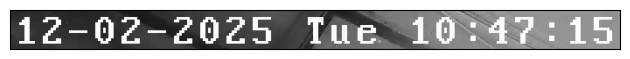

In [127]:
imgTensor, img = imageToTensorProcessor("testdata/D1.12-01-2025 Mon 10:05:58.jpg")
plot([imgTensor])
ocrRecognitionModel([imgTensor])

In [160]:
a = [0,1,2]
b = [3,4]
c = [*a, 4]
print(c)

[0, 1, 2, 4]
